In [1]:
import os
import sys

os.chdir("../..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Import custom FFNN implementation
import os
import sys
# Add the parent directory to path to import your modules
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from lib.neural import NeuralNetwork, NetworkLayer
from lib.ffnn import FFNN
from lib.activation import ReLU, Sigmoid, Tanh, Linear, Softmax
from lib.loss import MSE, BCE, CCE
from lib.weight_initializer import ZeroInitializer, UniformInitializer, NormalInitializer


INFO:root:Loading data


Sparsity with L1 penalty: 81.57%
Test score with L1 penalty: 0.8362
Example run in 37.637 s


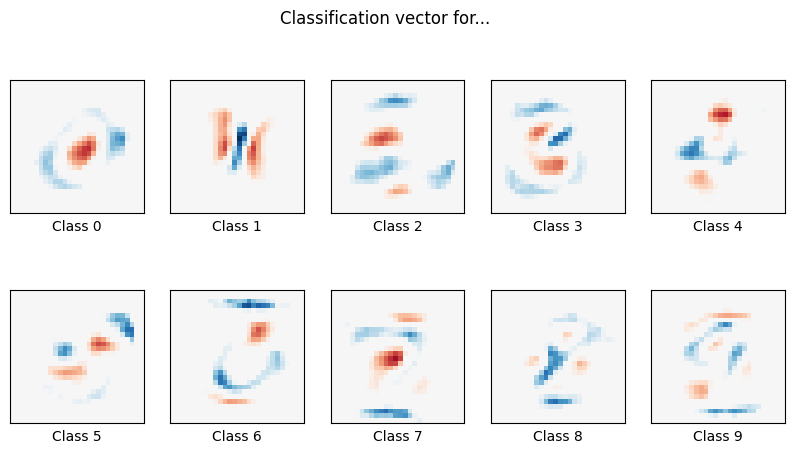

In [4]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import logging

logging.basicConfig(level=logging.INFO)

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
logging.info("Loading data")
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [6]:
# Preprocess data for FFNN
from sklearn.preprocessing import OneHotEncoder

# Load data (using your already loaded data)
# X_train and X_test are already loaded and scaled

# Convert labels to one-hot encoding for neural network
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Create validation set
X_train_ffnn, X_val, y_train_ffnn, y_val = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_ffnn.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Input features: {X_train.shape[1]}")
print(f"Output classes: {y_train_onehot.shape[1]}")

Training set: 4000 samples
Validation set: 1000 samples
Test set: 10000 samples
Input features: 784
Output classes: 10


In [7]:
# Helper functions for evaluation and visualization
def evaluate_model(model, X, y_onehot):
    """Evaluate model accuracy on given data."""
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_onehot, axis=1)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy

def plot_train_history(history, title="Training History"):
    """Plot training and validation loss history."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [27]:
# Define base configuration
base_config = {
    'learning_rate': 0.01,
    'batch_size': 32,
    'epochs': 5,  # Using fewer epochs for faster testing
    'loss_function': CCE(),
    'activation': ReLU(),
    'initializer': NormalInitializer(seed=42)
}

# Define different architectures for width variation (fixed depth)
width_variations = [
    [784, 32, 10],         # Narrow
    [784, 128, 10],        # Medium
    [784, 512, 10]         # Wide
]

# Define different architectures for depth variation (fixed width)
depth_variations = [
    [784, 64, 10],               # Shallow (1 hidden layer)
    [784, 64, 64, 10],           # Medium (2 hidden layers)
    [784, 64, 64, 64, 10]        # Deep (3 hidden layers)
]

# Test width variations
width_histories = []
width_accuracies = []

print("Testing width variations...")
for i, architecture in enumerate(width_variations):
    print(f"\nWidth Variation {i+1}: {architecture}")
    
    # Create activations list (output layer uses Softmax)
    activations = [base_config['activation']] * (len(architecture) - 2) + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_method=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=base_config['learning_rate'],
        verbose=1
    )
    
    # Store results
    width_histories.append(history)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    width_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot results for width variations
plt.figure(figsize=(15, 5))

# Plot width variation loss
plt.subplot(1, 2, 1)
for i, history in enumerate(width_histories):
    plt.plot(history['train_loss'], label=f"Width {width_variations[i][1]}")
plt.title('Training Loss vs Width')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare test accuracies for width
plt.subplot(1, 2, 2)
plt.bar([str(arch[1]) for arch in width_variations], width_accuracies)
plt.title('Test Accuracy vs Width')
plt.xlabel('Hidden Layer Width')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Test depth variations
depth_histories = []
depth_accuracies = []

print("\nTesting depth variations...")
for i, architecture in enumerate(depth_variations):
    print(f"\nDepth Variation {i+1}: {architecture}")
    
    # Create activations list (output layer uses Softmax)
    activations = [base_config['activation']] * (len(architecture) - 2) + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_method=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network, learning_rate=base_config['learning_rate'])
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=base_config['learning_rate'],
        verbose=1
    )
    
    # Store results
    depth_histories.append(history)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    depth_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot results for depth variations
plt.figure(figsize=(15, 5))

# Plot depth variation loss
plt.subplot(1, 2, 1)
for i, history in enumerate(depth_histories):
    plt.plot(history['train_loss'], label=f"Depth {len(depth_variations[i]) - 2}")
plt.title('Training Loss vs Depth')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare test accuracies for depth
plt.subplot(1, 2, 2)
plt.bar([str(len(arch) - 2) for arch in depth_variations], depth_accuracies)
plt.title('Test Accuracy vs Depth')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Testing width variations...

Width Variation 1: [784, 32, 10]


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (10,32) (320,320) 

Testing activation functions...

Activation: Linear


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 300.18it/s, loss=32.8571]


Epoch 1/5 - 0.42s - loss: 32.8571 - val_loss: 427.5186


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 266.28it/s, loss=9.6994]


Epoch 2/5 - 0.49s - loss: 9.6994 - val_loss: 329.2228


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 237.74it/s, loss=6.2385]


Epoch 3/5 - 0.55s - loss: 6.2385 - val_loss: 295.1182


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 254.34it/s, loss=4.5908]


Epoch 4/5 - 0.51s - loss: 4.5908 - val_loss: 270.0799


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 307.76it/s, loss=3.7406]


Epoch 5/5 - 0.42s - loss: 3.7406 - val_loss: 253.2818
Test accuracy: 0.8152

Activation: ReLU


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 168.54it/s, loss=29.0314]


Epoch 1/5 - 0.75s - loss: 29.0314 - val_loss: 359.3819


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 284.00it/s, loss=8.4532]


Epoch 2/5 - 0.45s - loss: 8.4532 - val_loss: 253.7747


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 274.26it/s, loss=5.0237]


Epoch 3/5 - 0.47s - loss: 5.0237 - val_loss: 216.3895


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 184.47it/s, loss=3.5620]


Epoch 4/5 - 0.70s - loss: 3.5620 - val_loss: 201.2358


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 328.98it/s, loss=2.6719]


Epoch 5/5 - 0.39s - loss: 2.6719 - val_loss: 193.3777
Test accuracy: 0.7964

Activation: Sigmoid


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 266.11it/s, loss=9.9943]


Epoch 1/5 - 0.48s - loss: 9.9943 - val_loss: 252.1164


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 219.22it/s, loss=7.2119]


Epoch 2/5 - 0.58s - loss: 7.2119 - val_loss: 198.4241


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 242.25it/s, loss=5.7817]


Epoch 3/5 - 0.53s - loss: 5.7817 - val_loss: 164.4352


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 289.88it/s, loss=4.8365]


Epoch 4/5 - 0.44s - loss: 4.8365 - val_loss: 141.1551


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 213.11it/s, loss=4.1810]


Epoch 5/5 - 0.60s - loss: 4.1810 - val_loss: 125.1106
Test accuracy: 0.5692

Activation: Tanh


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 295.04it/s, loss=13.1931]


Epoch 1/5 - 0.43s - loss: 13.1931 - val_loss: 289.7340


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 320.85it/s, loss=7.3250]


Epoch 2/5 - 0.40s - loss: 7.3250 - val_loss: 195.8187


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 272.85it/s, loss=5.0440]


Epoch 3/5 - 0.47s - loss: 5.0440 - val_loss: 156.0500


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 208.10it/s, loss=3.9292]


Epoch 4/5 - 0.61s - loss: 3.9292 - val_loss: 134.5535


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 335.01it/s, loss=3.2600]


Epoch 5/5 - 0.39s - loss: 3.2600 - val_loss: 121.0826
Test accuracy: 0.6491


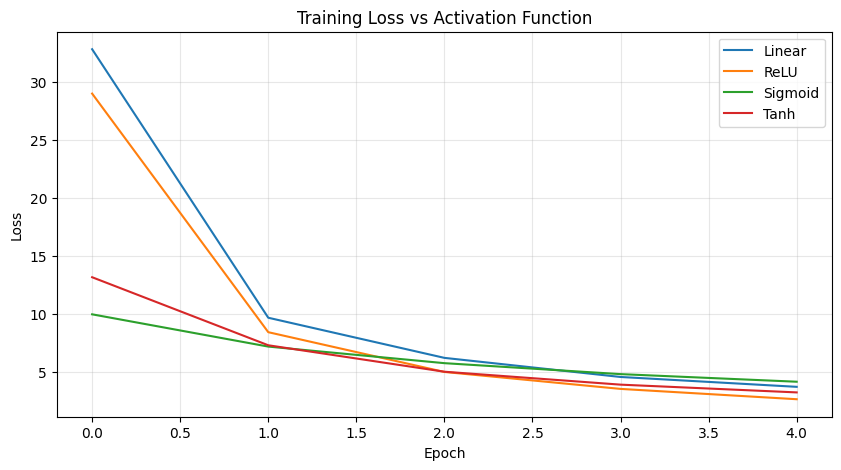

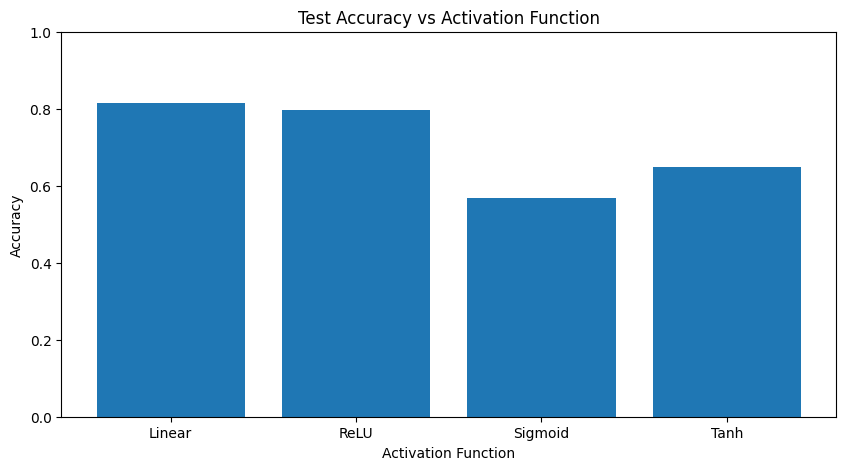

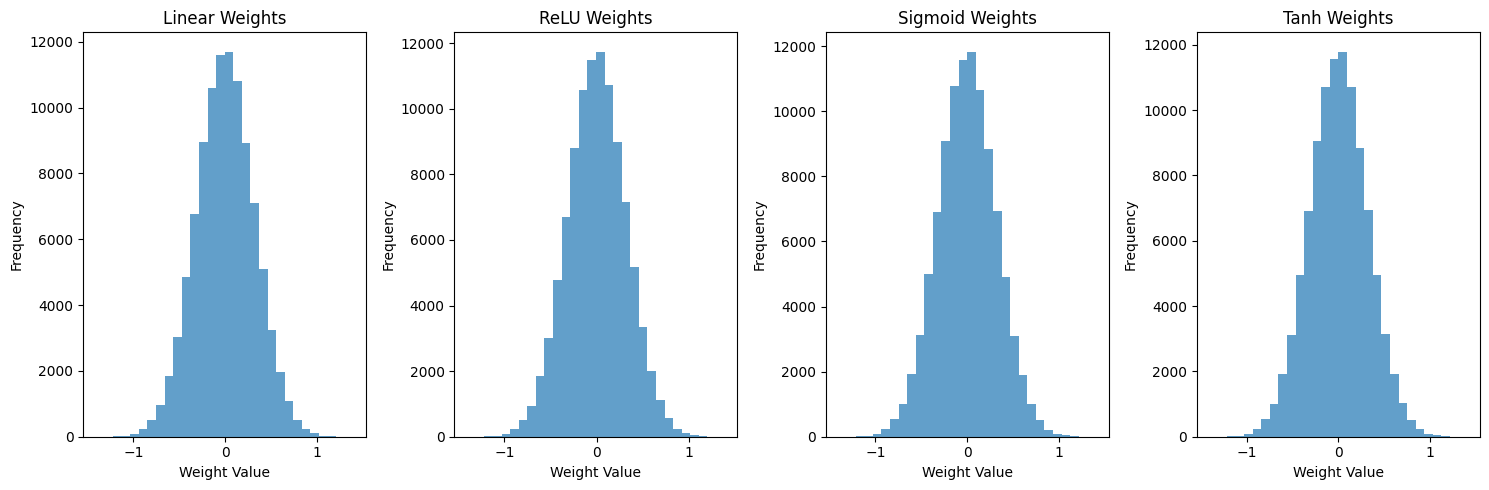

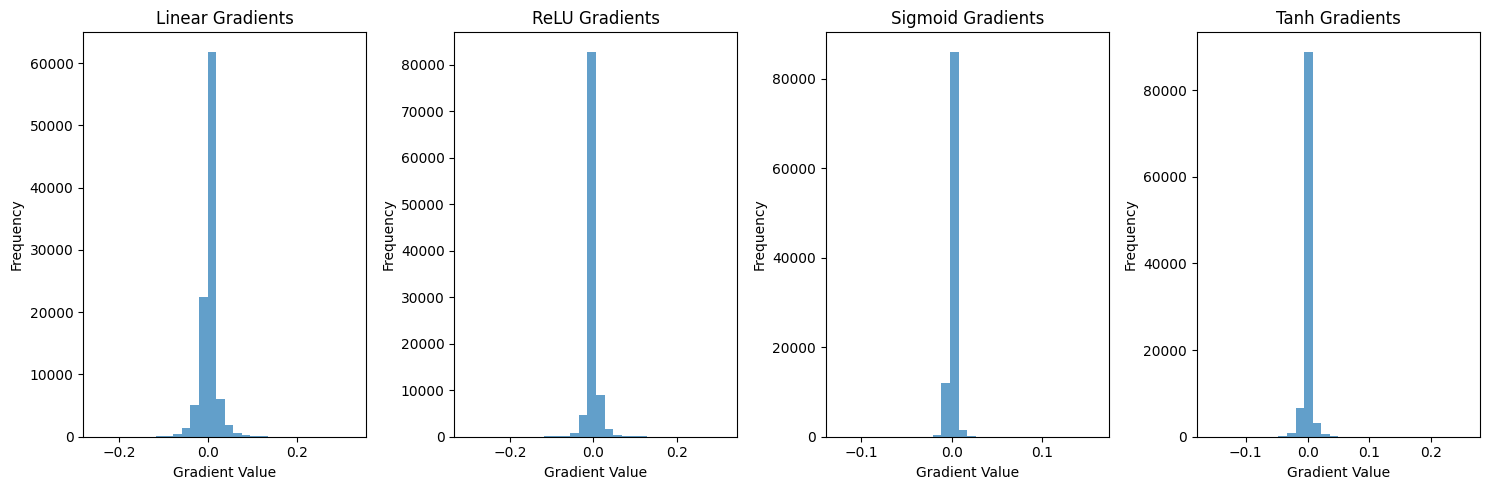

In [15]:
# Define base architecture
architecture = [784, 128, 10]

# Define activation functions to test (for hidden layers)
activation_functions = [Linear, ReLU, Sigmoid, Tanh]

# Test different activation functions
activation_histories = []
activation_accuracies = []
activation_models = []

print("Testing activation functions...")
for activation in activation_functions:
    print(f"\nActivation: {activation.__name__}")
    
    # Create activations list (output layer uses Softmax)
    activations = [activation] + [Softmax]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_method=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network, learning_rate=base_config['learning_rate'])
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Store results
    activation_histories.append(history)
    activation_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    activation_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(activation_histories):
    plt.plot(history['train_loss'], label=f"{activation_functions[i].__name__}")
plt.title('Training Loss vs Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar([act.__name__ for act in activation_functions], activation_accuracies)
plt.title('Test Accuracy vs Activation Function')
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(activation_models):
    plt.subplot(1, len(activation_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"{activation_functions[i].__name__} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot gradient distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(activation_models):
    plt.subplot(1, len(activation_models), i+1)
    gradients = model.network.gradients[0].flatten()
    plt.hist(gradients, bins=30, alpha=0.7)
    plt.title(f"{activation_functions[i].__name__} Gradients")
    plt.xlabel("Gradient Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Testing learning rates...

Learning Rate: 0.001


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 276.17it/s, loss=71.5911]


Epoch 1/5 - 0.46s - loss: 71.5911 - val_loss: 1596.5714


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 210.09it/s, loss=44.9281]


Epoch 2/5 - 0.62s - loss: 44.9281 - val_loss: 1100.5829


Epoch 3/5: 100%|██████████| 125/125 [00:02<00:00, 56.65it/s, loss=32.2194] 


Epoch 3/5 - 2.23s - loss: 32.2194 - val_loss: 835.0282


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 283.69it/s, loss=24.7990]


Epoch 4/5 - 0.45s - loss: 24.7990 - val_loss: 678.8933


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 203.77it/s, loss=20.1807]


Epoch 5/5 - 0.62s - loss: 20.1807 - val_loss: 578.4943
Test accuracy: 0.5230

Learning Rate: 0.01


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 257.59it/s, loss=28.7331]


Epoch 1/5 - 0.50s - loss: 28.7331 - val_loss: 349.1766


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 250.35it/s, loss=8.4101]


Epoch 2/5 - 0.51s - loss: 8.4101 - val_loss: 254.8069


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 189.46it/s, loss=5.1207]


Epoch 3/5 - 0.67s - loss: 5.1207 - val_loss: 217.6414


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 282.57it/s, loss=3.5671]


Epoch 4/5 - 0.46s - loss: 3.5671 - val_loss: 203.2286


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 234.08it/s, loss=2.6681]


Epoch 5/5 - 0.55s - loss: 2.6681 - val_loss: 194.4981
Test accuracy: 0.7974

Learning Rate: 0.1


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 210.69it/s, loss=18.1153]


Epoch 1/5 - 0.60s - loss: 18.1153 - val_loss: 311.0455


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 274.87it/s, loss=nan]


Epoch 2/5 - 0.47s - loss: nan - val_loss: 251.3127


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 285.39it/s, loss=nan]  


Epoch 3/5 - 0.45s - loss: nan - val_loss: 199.7943


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 205.51it/s, loss=nan]  


Epoch 4/5 - 0.62s - loss: nan - val_loss: 225.2678


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 210.88it/s, loss=nan]


Epoch 5/5 - 0.60s - loss: nan - val_loss: 210.7138
Test accuracy: 0.8725


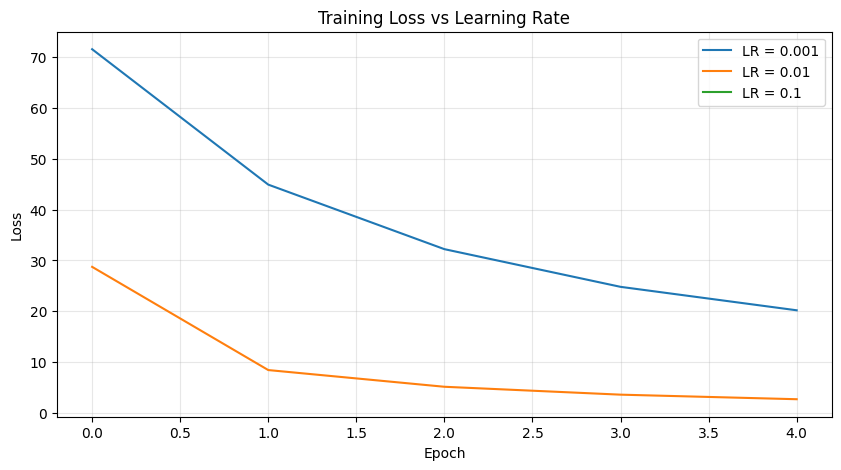

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


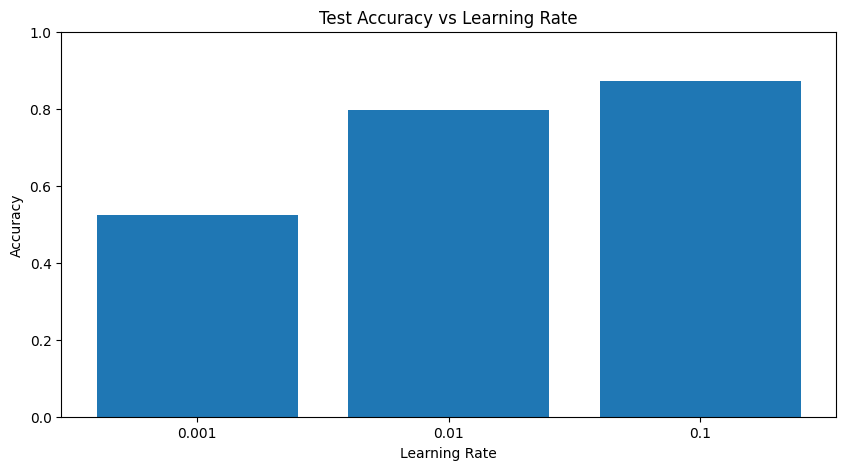

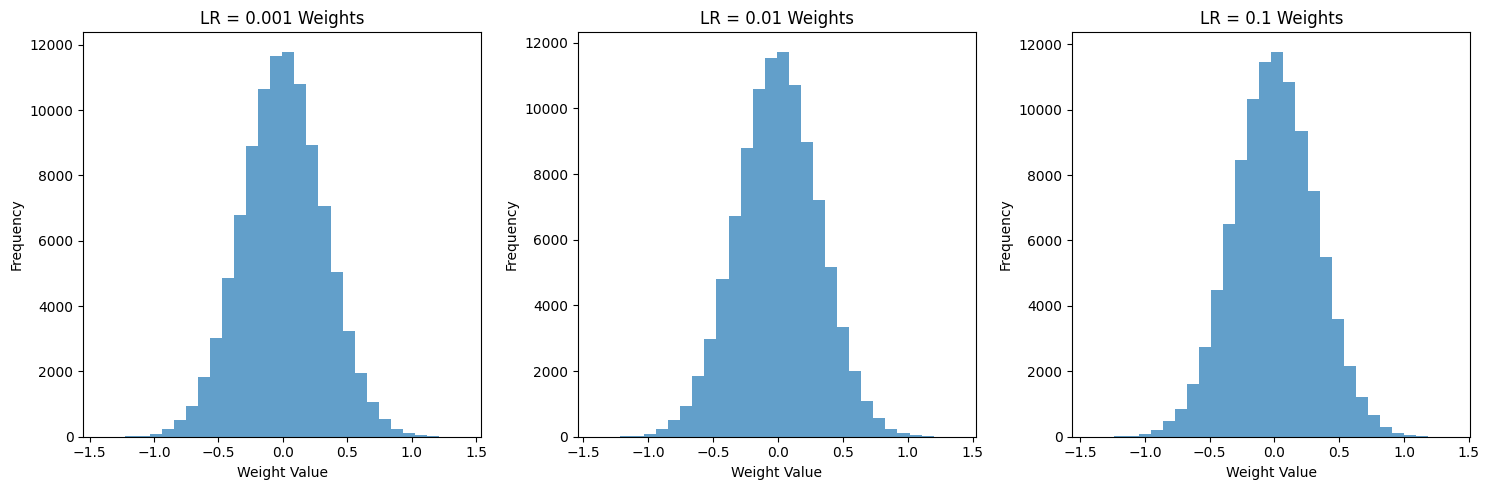

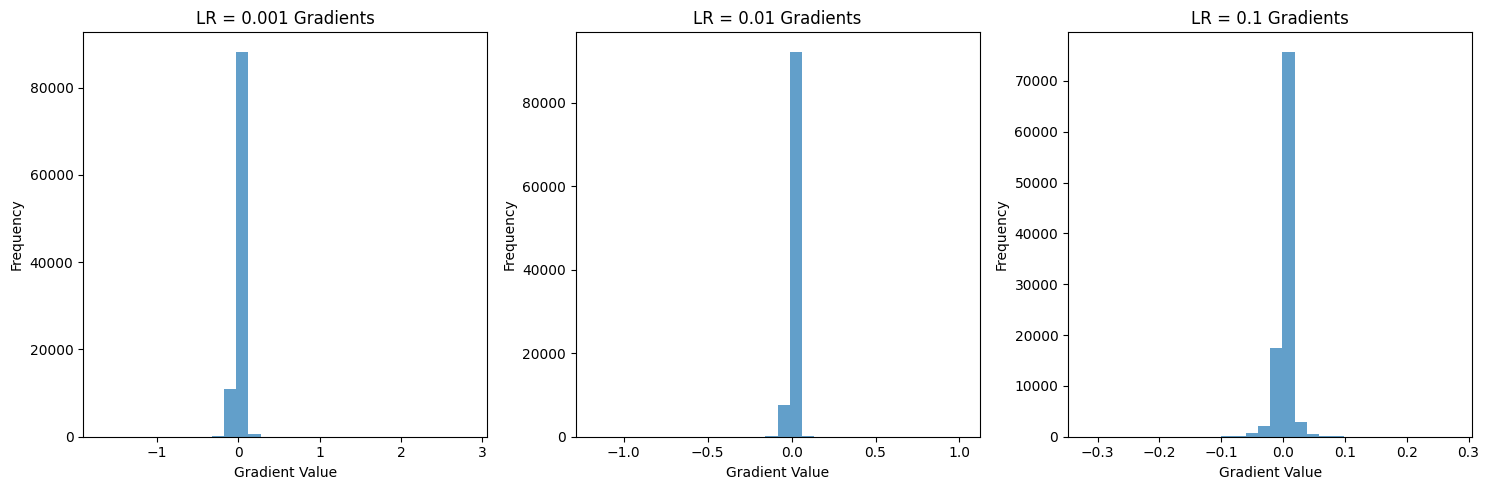

In [16]:
# Define base architecture
architecture = [784, 128, 10]

# Define learning rates to test
learning_rates = [0.001, 0.01, 0.1]

# Test different learning rates
lr_histories = []
lr_accuracies = []
lr_models = []

print("Testing learning rates...")
for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    
    # Create activations list (output layer uses Softmax)
    activations = [ReLU] + [Softmax]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_method=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network, learning_rate=lr)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Store results
    lr_histories.append(history)
    lr_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    lr_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(lr_histories):
    plt.plot(history['train_loss'], label=f"LR = {learning_rates[i]}")
plt.title('Training Loss vs Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar([str(lr) for lr in learning_rates], lr_accuracies)
plt.title('Test Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(lr_models):
    plt.subplot(1, len(lr_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"LR = {learning_rates[i]} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot gradient distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(lr_models):
    plt.subplot(1, len(lr_models), i+1)
    gradients = model.network.gradients[0].flatten()
    plt.hist(gradients, bins=30, alpha=0.7)
    plt.title(f"LR = {learning_rates[i]} Gradients")
    plt.xlabel("Gradient Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Testing weight initializers...

Initializer: Zero


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 233.12it/s, loss=7.3682]


Epoch 1/5 - 0.55s - loss: 7.3682 - val_loss: 230.2221


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 138.02it/s, loss=7.3674]


Epoch 2/5 - 0.92s - loss: 7.3674 - val_loss: 230.1924


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 276.31it/s, loss=7.3667]


Epoch 3/5 - 0.46s - loss: 7.3667 - val_loss: 230.1674


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 231.09it/s, loss=7.3661]


Epoch 4/5 - 0.55s - loss: 7.3661 - val_loss: 230.1487


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 172.15it/s, loss=7.3657]


Epoch 5/5 - 0.74s - loss: 7.3657 - val_loss: 230.1325
Test accuracy: 0.1017

Initializer: Uniform


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 295.49it/s, loss=5.1006]


Epoch 1/5 - 0.43s - loss: 5.1006 - val_loss: 104.7691


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 307.15it/s, loss=2.6989]


Epoch 2/5 - 0.42s - loss: 2.6989 - val_loss: 69.0990


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 218.44it/s, loss=1.8981]


Epoch 3/5 - 0.60s - loss: 1.8981 - val_loss: 55.2463


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 212.96it/s, loss=1.5131]


Epoch 4/5 - 0.60s - loss: 1.5131 - val_loss: 47.6437


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 267.15it/s, loss=1.2834]


Epoch 5/5 - 0.48s - loss: 1.2834 - val_loss: 43.0337
Test accuracy: 0.8727

Initializer: Normal


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 248.84it/s, loss=28.9417]


Epoch 1/5 - 0.51s - loss: 28.9417 - val_loss: 359.2118


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 209.36it/s, loss=8.5173]


Epoch 2/5 - 0.61s - loss: 8.5173 - val_loss: 259.6986


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 234.66it/s, loss=5.0221]


Epoch 3/5 - 0.55s - loss: 5.0221 - val_loss: 226.2524


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 346.10it/s, loss=3.6203]


Epoch 4/5 - 0.37s - loss: 3.6203 - val_loss: 203.8943


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 252.84it/s, loss=2.6855]


Epoch 5/5 - 0.51s - loss: 2.6855 - val_loss: 192.5261
Test accuracy: 0.7993


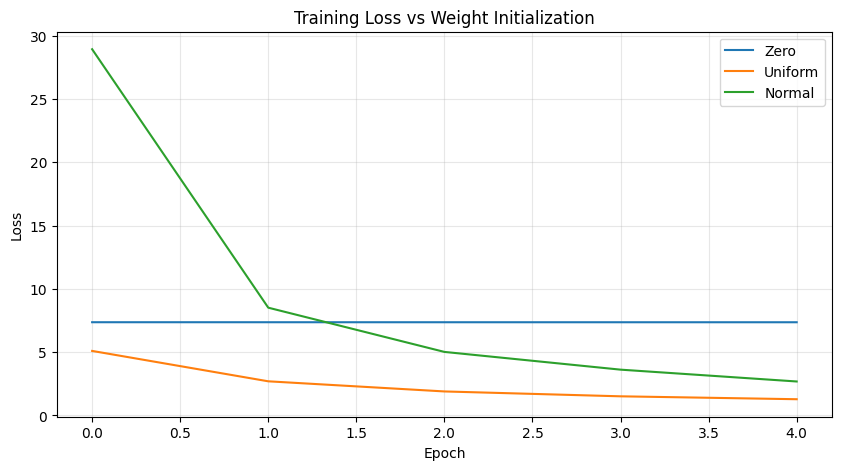

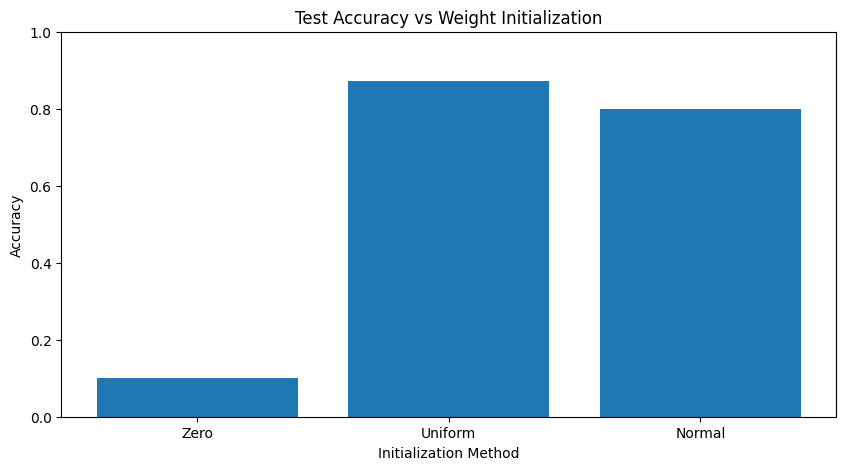

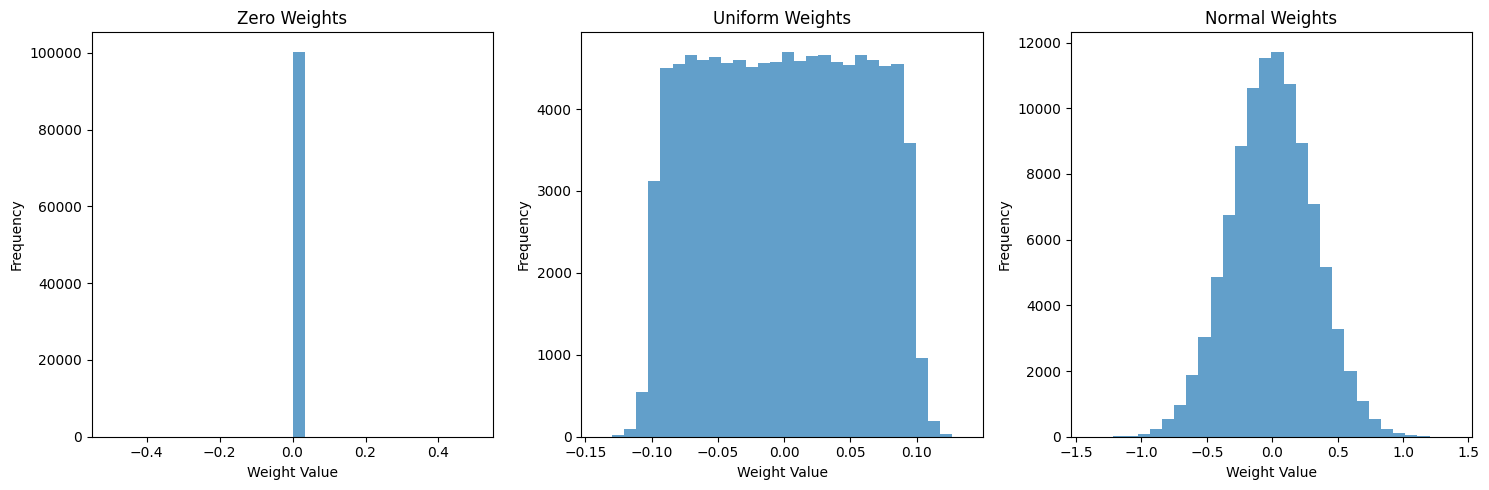

In [17]:
# Define base architecture
architecture = [784, 128, 10]

# Define initializers to test
initializers = [
    ZeroInitializer(),
    UniformInitializer(low=-0.1, high=0.1, seed=42),
    NormalInitializer(mean=0, var=0.1, seed=42)
]
initializer_names = ["Zero", "Uniform", "Normal"]

# Test different initializers
init_histories = []
init_accuracies = []
init_models = []

print("Testing weight initializers...")
for i, initializer in enumerate(initializers):
    print(f"\nInitializer: {initializer_names[i]}")
    
    # Create activations list (output layer uses Softmax)
    activations = [ReLU] + [Softmax]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_method=initializer
    )
    
    # Create FFNN model
    model = FFNN(network, learning_rate=base_config['learning_rate'])
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        verbose=1
    )
    
    # Store results
    init_histories.append(history)
    init_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    init_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(init_histories):
    plt.plot(history['train_loss'], label=f"{initializer_names[i]}")
plt.title('Training Loss vs Weight Initialization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar(initializer_names, init_accuracies)
plt.title('Test Accuracy vs Weight Initialization')
plt.xlabel('Initialization Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot initial weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(init_models):
    plt.subplot(1, len(init_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"{initializer_names[i]} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Training custom FFNN model...


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 244.58it/s, loss=28.6835]


Epoch 1/5 - 0.52s - loss: 28.6835 - val_loss: 354.5440


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 186.89it/s, loss=8.5292]


Epoch 2/5 - 0.69s - loss: 8.5292 - val_loss: 268.6090


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 311.80it/s, loss=5.0251]


Epoch 3/5 - 0.41s - loss: 5.0251 - val_loss: 228.3095


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 306.03it/s, loss=3.5474]


Epoch 4/5 - 0.42s - loss: 3.5474 - val_loss: 210.8440


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 241.36it/s, loss=2.7082]


Epoch 5/5 - 0.53s - loss: 2.7082 - val_loss: 193.0914

Training sklearn MLPClassifier...
First few training labels: [1 9 6 3 9]
Label type: <class 'numpy.ndarray'> int64
Iteration 1, loss = 0.55675701
Iteration 2, loss = 0.16665158
Iteration 3, loss = 0.09769208
Iteration 4, loss = 0.06162681
Iteration 5, loss = 0.03753452

Model Comparison:
Custom FFNN accuracy: 0.7970
sklearn MLP accuracy: 0.9243


/home/ganadipa/code/kuliah/sem6/Machine-learning/tubes-1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


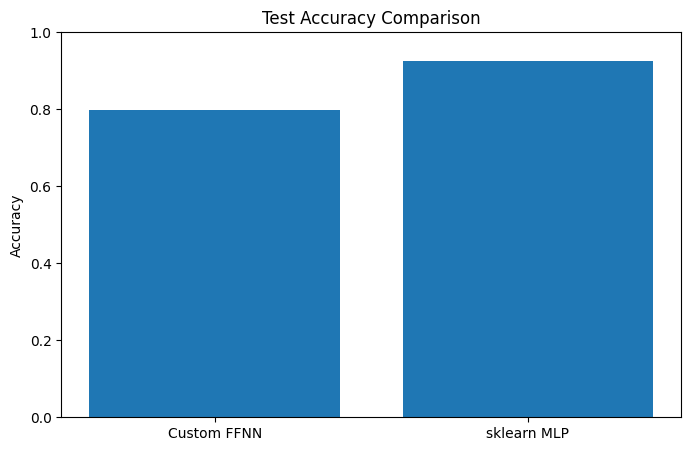

In [19]:
# Import sklearn's MLPClassifier
from sklearn.neural_network import MLPClassifier

# Define architecture and parameters
architecture = [784, 128, 10]
learning_rate = 0.01
batch_size = 32
epochs = 5

# Create our custom FFNN
activations = [ReLU] + [Softmax]
network = NeuralNetwork(
    node_counts=architecture,
    activations=activations,
    loss_function=CCE(),
    initialize_method=NormalInitializer(seed=42)
)
custom_model = FFNN(network, learning_rate=learning_rate)

# Train our custom model
print("Training custom FFNN model...")
custom_history = custom_model.fit(
    X_train_ffnn, y_train_ffnn,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1
)

# Create sklearn MLPClassifier
sklearn_model = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation='relu',
    solver='sgd',
    alpha=0.0001,
    batch_size=batch_size,
    learning_rate_init=learning_rate,
    max_iter=epochs,
    random_state=42,
    verbose=True
)

# Train sklearn model with correct target format
print("\nTraining sklearn MLPClassifier...")
# Convert string labels to integers if needed
y_train_int = np.array(y_train).astype(int) if isinstance(y_train[0], str) else np.array(y_train, dtype=int)
y_test_int = np.array(y_test).astype(int) if isinstance(y_test[0], str) else np.array(y_test, dtype=int)

# Check first few labels to debug
print(f"First few training labels: {y_train_int[:5]}")
print(f"Label type: {type(y_train_int)} {y_train_int.dtype}")

# Fit the model
sklearn_model.fit(X_train, y_train_int)

# Evaluate both models
custom_accuracy = evaluate_model(custom_model, X_test, y_test_onehot)
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_accuracy = np.mean(sklearn_predictions == y_test_int)

print("\nModel Comparison:")
print(f"Custom FFNN accuracy: {custom_accuracy:.4f}")
print(f"sklearn MLP accuracy: {sklearn_accuracy:.4f}")

# Compare accuracies
plt.figure(figsize=(8, 5))
plt.bar(['Custom FFNN', 'sklearn MLP'], [custom_accuracy, sklearn_accuracy])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()